
# **1.4 Subsequent Adjustments of Preprocessing** 

# **SC INFRASTRUCTURE**

## 1. Preparations
### 1.1 Install required packages

In [1]:
# check current python version and environment
!python --version

Python 3.12.2


In [2]:
# import required packages
import json
import os
import geopandas as gpd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import torch
import importlib

### 1.2 Set paths and directories to my personal WORKSPACE

In [3]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [4]:
# Input data 
# sparse multilabel-encoded masks (without background class 0)
masks_raw_dir =  r"/work/rf37uqip-MoSE_thesis/data/masks_raw/"

# preprocessed patches
patches_dir = r"/work/rf37uqip-MoSE_thesis/data/patches/"

# codes for classes
codes_dir =  r"/work/rf37uqip-MoSE_thesis/data/codes/"

In [5]:
# Output data
# one-hot-encoded masks
masks_dir =  r"/work/rf37uqip-MoSE_thesis/data/masks/"

# masks in class-index-format
# targets_dir = r"/work/rf37uqip-MoSE_thesis/data/targets/"

### 1.2 Load data

In [6]:
# Load class codes
################################################################################
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Totholz': 1, 'Wurzelstock': 2, 'Sand_Schlammbank': 3, 'Schotterbank': 4}


4

In [7]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[1]

'Totholz'

In [8]:
# Add background class to class codes (for One-Hot-Encoding)
################################################################################

label_codes_ohe = label_codes
# Add the background class
label_codes_ohe["Hintergrund"] = 0

# Save the updated label codes back to the file
# path
label_codes_ohe_path = os.path.join(codes_dir, "label_codes_ohe.json")
with open(label_codes_ohe_path, "w") as json_file:
        json.dump(label_codes_ohe, json_file, indent=4)

print(label_codes_ohe) 


{'Totholz': 1, 'Wurzelstock': 2, 'Sand_Schlammbank': 3, 'Schotterbank': 4, 'Hintergrund': 0}


In [9]:
# reversed dictionary
reversed_label_codes_ohe = {v: k for k, v in label_codes_ohe.items()} # v = value, k = key
reversed_label_codes_ohe[0]

'Hintergrund'

In [10]:
################################################################################
# Load masks
################################################################################

masks_raw_list = [f for f in os.listdir(masks_raw_dir)]  # list of all masks
len(masks_raw_list)
# masks_list

2558

Shape of the mask: (4, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 2
Unique values: [0 1 2]


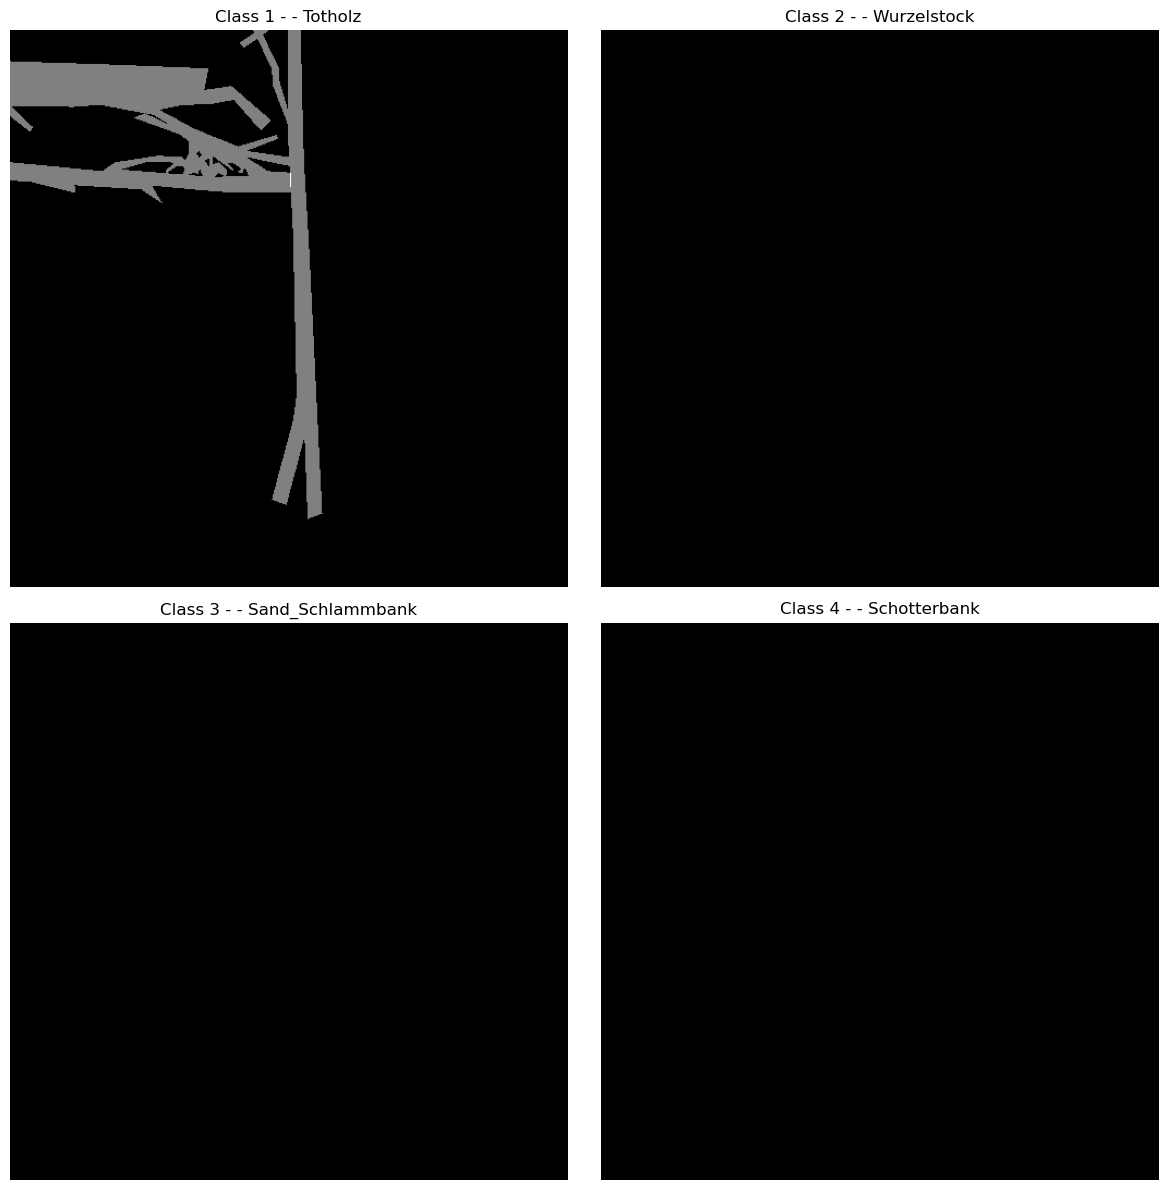

In [13]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen raw mask
test_mask_raw_path = masks_raw_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load raw mask
test_mask_raw = np.load(test_mask_raw_path)

# Show properties of the mask
print("Shape of the mask:", test_mask_raw.shape)
print("Datatype:", test_mask_raw.dtype)
print("Type:", type(test_mask_raw))
print("Minimum value:", np.min(test_mask_raw))
print("Maximum value:", np.max(test_mask_raw))
print("Unique values:", np.unique(test_mask_raw)) # binary mask

# Plot the mask
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid (for 4 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask_raw.shape[0]):  # iterate through the 4 classes
  axes[i].imshow(test_mask_raw[i], cmap="gray")
  axes[i].set_title(f"Class {i + 1} - - {reversed_label_codes_ohe[i + 1]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

# 2. One-Hot-Encoding

Current masks are not one-hot-encoded, but sparse multilabel encoded (resp. multilabel binary representation). 
Short explanation with an example:

1) Sparse Multilabel Encoding

> Channel 1: 0 0 1  
> Channel 2: 0 0 0   
> Channel 3: 0 1 1   
> = Sum of all channels per pixel can be 0 or bigger than 1. A pixel can be assigned to no class (background) or more than one class.     

Advantages:
Efficient for sparse labels: This representation is well suited if the background (or empty areas) occurs frequently, as memory is saved by not explicitly modeling the background.
Flexibility: This representation allows a pixel to belong to none or several classes at the same time (which can be useful for overlap).

Disadvantages:
Customize loss function: Classic loss functions like CrossEntropyLoss, which assume one-hot encoding, do not work directly here because they expect an explicit background or clear class assignment per pixel. Instead, DiceLoss or BCEWithLogitsLoss are more suitable for your representation.
Interpret performance: The background class is not modeled directly here, which can make it difficult to evaluate model performance (e.g. how well the model separates the background).

2) One-Hot-Encoding

> Channel 1: 0 0 1   
> Channel 2: 1 0 0   
> Channel 3: 0 1 0   
> = Sum of all channels per pixel has to be always 1. A pixel is always assigned to exactly one class (background class has its own channel)!   

In [17]:
def convert_to_one_hot_encoded_masks(masks_raw_dir, masks_ohe_dir):
    """
    Converts Sparse Multilabel Masks to One-Hot-Encoded Masks with a background class.

    Args:
        masks_raw_dir (str): Path to the directory containing sparse multilabel masks.
        masks_ohe_dir (str): Path to the directory to save one-hot-encoded masks.
    """
    
    masks_raw_list = [f for f in os.listdir(masks_raw_dir) if f.endswith('_mask.npy')]  # List of all masks
    masks_raw_list.sort()  # Sort list alphabetically

    for mask_name in masks_raw_list:
        # Load mask
        mask_raw_path = os.path.join(masks_raw_dir, mask_name)
        mask_raw = np.load(mask_raw_path)  # Shape: (4, 512, 512)

        # Check for conflicts (pixels belonging to multiple classes)
        conflict_mask = mask_raw.sum(axis=0) > 1  # Shape: (512, 512), True for conflicting pixels

        # Create new mask with an extra channel for the background
        one_hot_mask = np.zeros(((mask_raw.shape[0] + 1), mask_raw.shape[1], mask_raw.shape[2]), dtype=np.uint8)  # Shape: (5, 512, 512)

        # Assign background class
        one_hot_mask[0] = conflict_mask | (mask_raw.sum(axis=0) == 0)  # Background = conflicts or no class

        # Assign the remaining classes
        one_hot_mask[1:] = mask_raw

        # Remove conflicting pixel assignments from all other classes
        one_hot_mask[1:] *= ~conflict_mask  # Set other class values to 0 if pixel is in conflict

        # Save the new mask
        output_path = os.path.join(masks_ohe_dir, mask_name)
        np.save(output_path, one_hot_mask)

    print(f"Converted masks saved to: {masks_ohe_dir}")


In [ ]:
convert_to_one_hot_encoded_masks(masks_raw_dir, masks_dir)

In [ ]:
################################################################################
# Load one-hot-encoded masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
len(mask_list)
# masks_list

Shape of the mask: (10, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


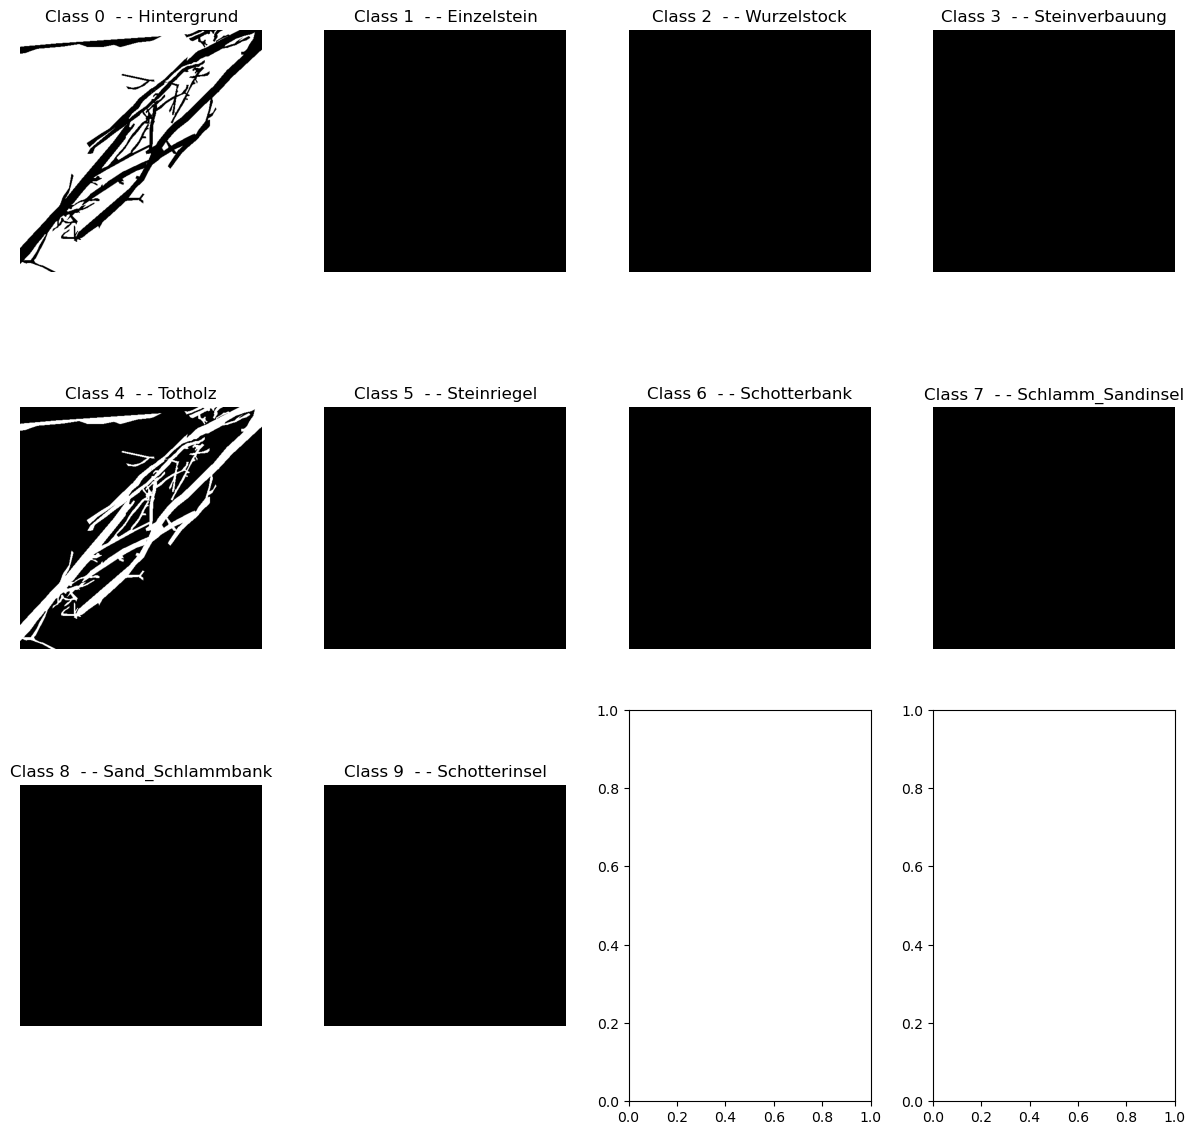

In [55]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 1054 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask)) # binary mask

# Plot the mask
fig, axes = plt.subplots(3, 4, figsize=(12, 12))  # 4x3 grid (for 10 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the 10 classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i}  - - {reversed_label_codes_ohe[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

# 3. Class-Index-format

CrossEntropyLoss can not deal with one-hot-encoded masks (shape: [batch_size, num_classes, height, width]) in this case. Because the raw logits (input) have the shape [batch_size, num_classes, height, width], the targets must have the shape [batch_size, height, width] to fit into the loss function. Therefore we convert the masks into this format, where every pixel has an index value between 0 and 9 corresponding to his classification (true label).

In [ ]:
for mask_file in masks_ohe_list:
    # load masks
    mask_path = os.path.join(masks_ohe_dir, mask_file)
    mask_ohe = np.load(mask_path)  # One-Hot-Encoded mask

    # Conversion into Class-Index-Format
    targets = np.argmax(mask_ohe, axis=0)  # Axis=0, because 
    # print(targets.shape)  # shape: [512, 512]

    # Save new target mask
    target_path = os.path.join(targets_dir, mask_file)
    np.save(target_path, targets)

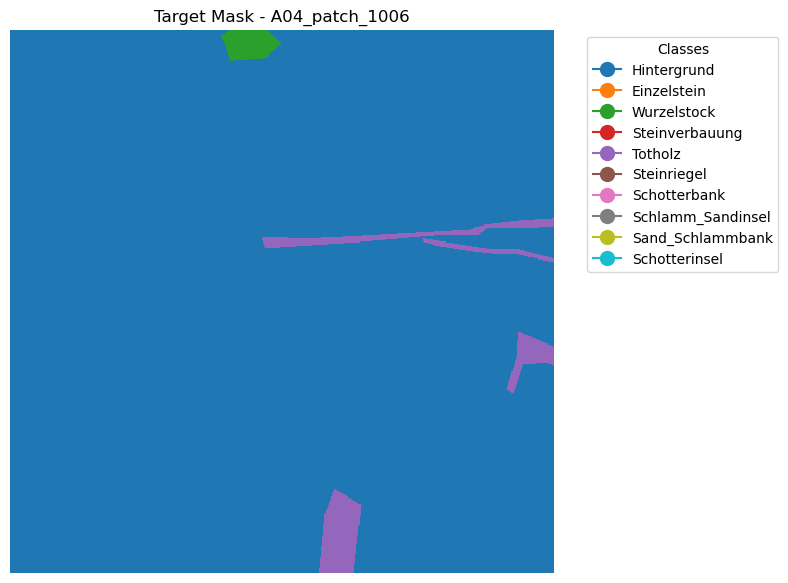

In [98]:
################################################################################
# Test Target
################################################################################

##################################
# choose target by SECTION and ID
SECTION = "A04"  # -------------------->> adjustable
TEST_MASK_ID = 1006  # -------------------->> adjustable
###############################

# path to target
target_path = f"{targets_dir}/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# load target
test_target = np.load(target_path)

# generate colors with matplotlib
colors = plt.cm.tab10(np.linspace(0, 1, len(reversed_label_codes_ohe)))  # 10 Farben
cmap = plt.matplotlib.colors.ListedColormap(colors)

# plot target
plt.figure(figsize=(8, 8))
plt.imshow(test_target, cmap=cmap, vmin=0, vmax=len(reversed_label_codes_ohe) - 1, interpolation='nearest') # deactivate interpolation
plt.title(f"Target Mask - {SECTION}_patch_{TEST_MASK_ID}")
plt.axis("off")

# add legend
legend_elements = [
    plt.Line2D([0], [0], marker="o", color=colors[i], markersize=10, label=reversed_label_codes_ohe[i])
    for i in range(len(reversed_label_codes_ohe))
]
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# 4. Unzip patches (without background patches)

Because the training of the model lasts very long, I searched for ways of reducing the computational effort!
Maybe this measure can improve it!

In [100]:
# INPUT
# .npz-patches directory 
# local copy of .npz-compressed preprocessed_patches without background patches
patches_npz_dir = r"C:\Users\simon\Documents\Lokal\Bachelorareit_lokal\data_local\patches_with_masks\preprocessed_patches_zip"

# OUTPUT
# new preprocessed_patches_unz folder with unzipped patches
patches_unz_dir = r"C:\Users\simon\Documents\Lokal\Bachelorareit_lokal\data_local\patches_with_masks\preprocessed_patches_unz"

In [101]:
# list of all .npz-files (preprocessed patches with .npz-compression)
################################################################################
patches_npz_list = [f for f in os.listdir(patches_npz_dir) if f.endswith('.npz')]
patches_npz_list[0:3]

['A01_patch_0.npy.npz', 'A01_patch_1.npy.npz', 'A01_patch_103.npy.npz']

In [102]:
def unzip_npz_and_save(patch_npz_name, patches_npz_dir, patches_unz_dir):

    """ 
     Load a patch .npz file, extract the first array, and save it as a .npy file in the specified directory.

    Args:
        patch_npz_name (str): Name of the patch .npz file.
        patches_npz_dir (str): Directory where patch .npz files are stored.
        patches_unz_dir (str): Directory where unzipped patch .npy files will be stored.
    """

    patch_npz_path = os.path.join(patches_npz_dir, patch_npz_name) # path to .npz-file

    try:
        with np.load(patch_npz_path, mmap_mode='r') as data:  # Load the patch .npz-file
        # use memory mapping (mmap_mode='r') for more efficient loading
        # (without loading the total content into RAM)

            array_keys = list(data.keys())  # Get all keys (array names)

            if len(array_keys) > 1:  # Print a warning if multiple arrays are present
                print(f".npz-file '{patch_npz_name}' contains {len(array_keys)} arrays: {array_keys}")

            patch_name = patch_npz_name.replace(".npz", "")  # Remove '.npz' to get the base name

            patch_image = data[array_keys[0]]  # Extract the first array

            # Save the unzipped patch as .npy
            patch_npy_path = os.path.join(patches_unz_dir, patch_name)
            np.save(patch_npy_path, patch_image)

    except Exception as e:  # Handle any errors during file loading
        print(f"Error loading {patch_npz_name}: {e}")
        return None

In [103]:
# Unzip all files in the preprocessed_patches_zip-Folder and save them
for patch_npz_name in patches_npz_list:
    unzip_npz_and_save(patch_npz_name, patches_npz_dir, patches_unz_dir)

print("Unzipping and saving completed.")

Unzipping and saving completed.
